# Прогнозирование оттока клиентов

## Описание проекта

**Цель:** Оператору связи необходимо научисться прогнозировать отток клиентов для планирования предиктивных мер (скидок, особых условий).  
Для выборки клиентов доступны персональные данные, информация о тарифах и договорах.  
Информация о договорах актуальна на *1 февраля 2020*.    
- Основная метрика для проверки качества модели: `roc_auc`  
- Дополнительная метрика: `accuracy`  
  
### Описание Услуг
1) Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.  
2) Интернет. Подключение может быть двух типов: через телефонную линию DSL или оптоволоконный кабель Fiber optic.  

**Дополнительные услуги:**  
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

### Описание данных
Данные состоят из файлов, полученных из разных источников:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

**План выполнения работы:**  
- [1. Исследовательский анализ данных](#секция1)  
    - [1.1 Загрузка данных](#секция1.1)  
    - [1.2 Предобработка данных](#секция1.2)  
    - [1.3 Анализ данных и отбор признаков](#секция1.3)   
- [2. Выбор и обучение модели](#секция2)  
    - [2.1 Base-line модель ](#секция2.1)  
    - [2.2 Логистическая регрессия](#секция2.2)  
    - [2.3 Random Forest](#секция2.3)  
    - [2.4 Градиентный бустинг (CatBoost)](#секция2.4)  
- [3. Общий вывод](#секция3)  

<a id='секция1'></a>
# 1 Исследовательский анализ данных

<a id='секция1.1'></a>
## 1.1 Загрузка данных

Подключаем библиотеки:
- `pandas` - для работы с таблицами  
- `seaborn` - для визуализации данных
- `sklearn` - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)

In [1]:
import sys
sys.setrecursionlimit(10000)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from imblearn.over_sampling import SMOTE
from lofo import LOFOImportance, Dataset, plot_importance
from tqdm.autonotebook import tqdm

C:\Users\defaultuser0\miniconda3\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
contract = pd.read_csv('final_provider/contract.csv', index_col='customerID')
internet = pd.read_csv('final_provider/internet.csv', index_col='customerID')
personal = pd.read_csv('final_provider/personal.csv', index_col='customerID')
phone = pd.read_csv('final_provider/phone.csv', index_col='customerID')

<a id='секция1.2'></a>
## 1.2 Предобработка данных

- Для всех полей преобразуем данные в удобный для обработки формат (строки в числовые категории, datetime и др.)
- При наличии, обработаем пропуски и выбросы

**1) contract**

In [3]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [4]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
contract['BeginDate'] = contract['BeginDate'].astype('datetime64')

In [6]:
UPLOAD_DATE = '2020-02-01'
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = UPLOAD_DATE
contract['EndDate'] = contract['EndDate'].astype('datetime64')

In [7]:
# contract['TotalCharges'] = contract['TotalCharges'].astype('float64')
print(f"Количество незаполненных полей TotalCharges: {len(contract.loc[contract['TotalCharges'] == ' '])}")
beg_date = contract.loc[contract['TotalCharges'] == ' ', 'BeginDate'].unique()
print(f"Значения BeginDate для пользователей с пустым TotalCharges: {beg_date}")

Количество незаполненных полей TotalCharges: 11
Значения BeginDate для пользователей с пустым TotalCharges: ['2020-02-01T00:00:00.000000000']


В поле TotalCharges значения пропущения для пользователей, подключенных к тарифу в день выгрузки базы данных (2020-02-01). Эти пользователи не интересны для исследования, их мало (11 клиентов), удалим их из выборки.

In [8]:
contract = contract.loc[contract['TotalCharges'] != ' ']
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

Преобразуем поле Type: 0 - Month-to-month, 1 - One year, 2 - Two year

In [9]:
def transform_type(ptype):
    if ptype == 'Month-to-month' :
        res = 0
    elif ptype == 'One year' :
        res = 1
    elif ptype == 'Two year' :
        res = 2
    return res
contract['Type'] = contract['Type'].apply(transform_type).astype('int8')

In [10]:
def transform_payment_method(pmethod):
    if pmethod == 'Electronic check' :
        res = 0
    elif pmethod == 'Mailed check' :
        res = 1
    elif pmethod == 'Bank transfer (automatic)' :
        res = 2
    elif pmethod == 'Credit card (automatic)' :
        res = 3
    return res
contract['PaymentMethod'] = contract['PaymentMethod'].apply(transform_payment_method).astype('int8')

In [11]:
contract['PaperlessBilling'] = (contract['PaperlessBilling'] == 'Yes').astype('int8')

In [12]:
contract['begin_days'] = (pd.Timestamp(UPLOAD_DATE) - contract['BeginDate']) // np.timedelta64(1, 'D')
contract.drop('BeginDate', axis=1, inplace=True)

In [13]:
contract['end_days'] = (pd.Timestamp(UPLOAD_DATE) - contract['EndDate']) // np.timedelta64(1, 'D')
contract.drop('EndDate', axis=1, inplace=True)

In [14]:
contract['churn'] = (contract['end_days'] > 0).astype('int8')

In [15]:
contract.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,churn
customerID,,,,,,,,
7590-VHVEG,0,1,0,29.85,29.85,31,0,0
5575-GNVDE,1,0,1,56.95,1889.50,1036,0,0
3668-QPYBK,0,1,1,53.85,108.15,123,62,1
7795-CFOCW,1,0,2,42.30,1840.75,1371,0,0
9237-HQITU,0,1,0,70.70,151.65,153,92,1


**2) personal**

In [16]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [17]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [18]:
personal['if_male'] = (personal['gender'] == 'Male').astype('int8')
personal.drop('gender', axis=1, inplace=True)

In [19]:
personal['Partner'] = (personal['Partner'] == 'Yes').astype('int8')
personal['Dependents'] = (personal['Dependents'] == 'Yes').astype('int8')

In [20]:
personal.head()

,SeniorCitizen,Partner,Dependents,if_male
customerID,,,,
7590-VHVEG,0,1,0,0
5575-GNVDE,0,0,0,1
3668-QPYBK,0,0,0,1
7795-CFOCW,0,0,0,1
9237-HQITU,0,0,0,0


**3) internet**

In [21]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [22]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [23]:
internet['fiber_optic'] = (internet['InternetService'] == 'Fiber optic').astype('int8')
internet.drop('InternetService', axis=1, inplace=True)

In [24]:
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    internet[col] = (internet[col] == 'Yes').astype('int8')

In [25]:
internet.head()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic
customerID,,,,,,,
7590-VHVEG,0,1,0,0,0,0,0
5575-GNVDE,1,0,1,0,0,0,0
3668-QPYBK,1,1,0,0,0,0,0
7795-CFOCW,1,0,1,1,0,0,0
9237-HQITU,0,0,0,0,0,0,1


**4) phone**

In [26]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [27]:
phone['MultipleLines'] = (phone['MultipleLines'] == 'Yes').astype('int8')

In [28]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,0
3668-QPYBK,0
9237-HQITU,0
9305-CDSKC,1
1452-KIOVK,1


**5) Объединение данных**

 При объединении таблиц заполним пустые значения признаков `-1`. Будем считать, что клиент не пользуется данными услугами.

In [29]:
df = contract.join(personal, how='left').join(internet, how='left').join(phone, how='left').fillna(-1)

In [30]:
for col in list(internet.columns) + list(phone.columns):
    df[col] = df[col].fillna(-1).astype('int8')

In [31]:
df = pd.concat([df['churn'], df.drop('churn', axis=1)], axis=1)
df.head(10)

,churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,SeniorCitizen,Partner,Dependents,if_male,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,29.85,29.85,31,0,0,1,0,0,0,1,0,0,0,0,0,-1
5575-GNVDE,0,1,0,1,56.95,1889.50,1036,0,0,0,0,1,1,0,1,0,0,0,0,0
3668-QPYBK,1,0,1,1,53.85,108.15,123,62,0,0,0,1,1,1,0,0,0,0,0,0
7795-CFOCW,0,1,0,2,42.30,1840.75,1371,0,0,0,0,1,1,0,1,1,0,0,0,-1
9237-HQITU,1,0,1,0,70.70,151.65,153,92,0,0,0,0,0,0,0,0,0,0,1,0
9305-CDSKC,1,0,1,0,99.65,820.50,337,92,0,0,0,0,0,0,1,0,1,1,1,1
1452-KIOVK,0,0,1,3,89.10,1949.40,671,0,0,0,1,1,0,1,0,0,1,0,1,1
6713-OKOMC,0,0,0,1,29.75,301.90,306,0,0,0,0,0,1,0,0,0,0,0,0,-1
7892-POOKP,1,0,1,0,104.80,3046.05,945,92,0,1,0,0,0,0,1,1,1,1,1,1


<a id='секция1.3'></a>
## 1.3 Анализ данных и отбор признаков

In [32]:
df.describe()

,churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,begin_days,end_days,SeniorCitizen,Partner,Dependents,if_male,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic,MultipleLines
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,0.688567,0.592719,1.315557,64.798208,2283.300441,1008.031428,20.492890,0.162400,0.482509,0.298493,0.504693,0.070392,0.128697,0.127702,0.073948,0.168231,0.172213,0.224118,0.325228
std,0.441782,0.832934,0.491363,1.149523,30.085974,2266.771362,736.095040,38.301177,0.368844,0.499729,0.457629,0.500014,0.705562,0.737917,0.737415,0.707715,0.756518,0.758252,0.778643,0.642585
min,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,35.587500,401.450000,306.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,70.350000,1397.475000,883.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,2.000000,89.862500,3794.737500,1706.000000,31.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,2314.000000,123.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='churn', ylabel='MonthlyCharges'>

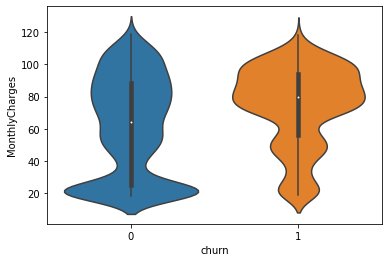

In [33]:
sns.violinplot(x='churn', y='MonthlyCharges', data=df)

- Разделим MonthlyCharges на два признака: оплата дешевых тарифов (< 38) и оплата дорогих тарифов (>= 38)

<AxesSubplot:xlabel='churn', ylabel='TotalCharges'>

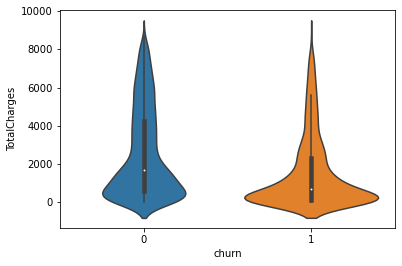

In [34]:
sns.violinplot(x='churn', y='TotalCharges', data=df)

На графиках "violin" видно, что в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся. Возможно, они переплачивали за ненужные сервисы. 'TotalCharges' же больше у оставшихся клиентов.

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

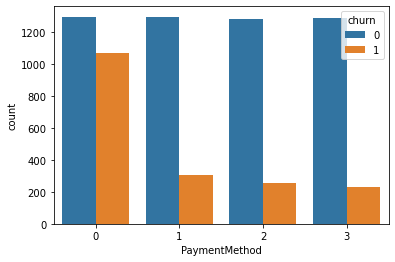

In [35]:
sns.countplot(x='PaymentMethod', hue='churn', data=df)

Многие ушедшие клиенты расплачивались методом 'Electronic check'.

<AxesSubplot:xlabel='Type', ylabel='count'>

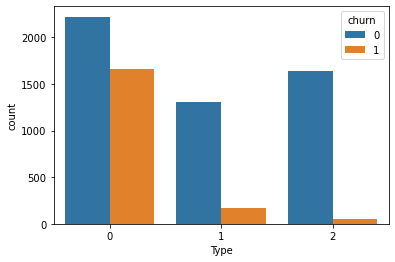

In [36]:
sns.countplot(x='Type', hue='churn', data=df)

<AxesSubplot:xlabel='churn', ylabel='begin_days'>

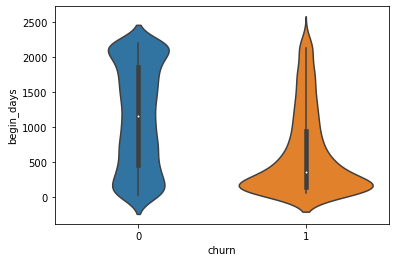

In [37]:
sns.violinplot(x='churn', y='begin_days', data=df)

Многие ушедшие клиенты начали пользоваться услугами в последний год.

<AxesSubplot:xlabel='fiber_optic', ylabel='count'>

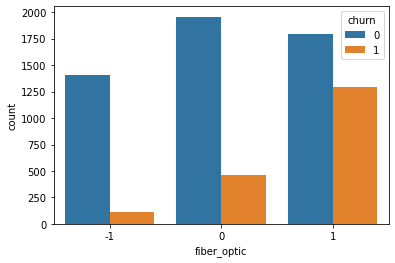

In [38]:
sns.countplot(x='fiber_optic', hue='churn', data=df)

- Многие ушедшие клиенты были подключены по оптоволокну. 
- Среди клиентов, не пользовавшихся услугами интернета (fiber_optic = -1), отток сравнительно небольшой

**2) Матрица корреляции**

- Построим матрицу корреляции для количественных признаков

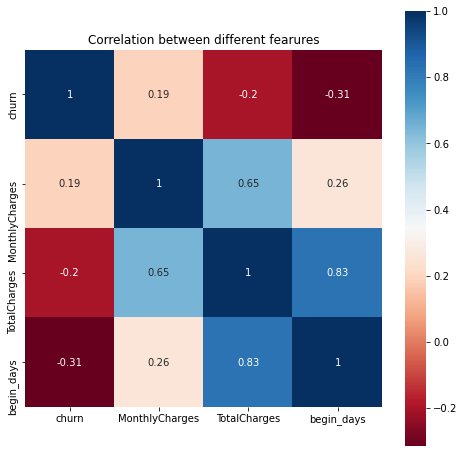

In [39]:
cor_columns = ['churn', 'MonthlyCharges', 'TotalCharges', 'begin_days']
correlation = df[cor_columns].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='RdBu')

plt.title('Correlation between different fearures')
plt.show()

**3) Отбор признаков**

- Добавим признак 'service_days' - количество месяцев пользования сервисами. 

In [40]:
df['lifetime'] = df['begin_days'] - df['end_days']

In [41]:
df.drop(['begin_days', 'end_days', 'if_male'], axis=1, inplace=True)

In [42]:
num_columns = ['MonthlyCharges', 'TotalCharges', 'lifetime']
cat_columns = [col for col in list(df.columns) if col not in num_columns and col != 'churn']

In [43]:
df.head()

,churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,fiber_optic,MultipleLines,lifetime
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,29.85,29.85,0,1,0,0,1,0,0,0,0,0,-1,31
5575-GNVDE,0,1,0,1,56.95,1889.50,0,0,0,1,0,1,0,0,0,0,0,1036
3668-QPYBK,1,0,1,1,53.85,108.15,0,0,0,1,1,0,0,0,0,0,0,61
7795-CFOCW,0,1,0,2,42.30,1840.75,0,0,0,1,0,1,1,0,0,0,-1,1371
9237-HQITU,1,0,1,0,70.70,151.65,0,0,0,0,0,0,0,0,0,1,0,61


#### Выводы

- Данные успешно загружены и обработаны. Большие выбросы сред данных отсутствуют. Строковые типы преобразованы к числовым категориям.
- Проведён анализ признаков. 
    - в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся
    - многие ушедшие клиенты расплачивались методом 'Electronic check'
    - большинство ушедших клиентов были подключены по оптоволокну.
    - среди клиентов, не пользовавшихся услугами интернета (fiber_optic = -1), отток сравнительно небольшой  
- Построена матрица корреляции и отобраны наиболее релевантные для модели признаки

<a id='секция2'></a>
# 2 Выбор и обучение модели

In [44]:
df['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

Отношение ушедших клиентов к оставшимся в выборке примерно 3:1. Нет необходимости искусственно изменять это соотношение с помощью upsampling, но при разделении данных на train-validation-test надо учесть это соотношение.

### Разделение выборки

 - Выделим признаки и целевой признак. 

In [45]:
X = df.drop('churn', axis=1)
y = df['churn']

- Разделим данные на тренировочную и тестовую выборку в соотношении 4:1. При разделении учтем баланс классов целевого признака.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (5625, 17)
Размер тестовой выборки: (1407, 17)


<a id='секция2.1'></a>
### 2.1 Base-line модель 

В качестве base-line моделей используем константную модель (все объекты класса 0, соответствующего оставшимся клиентам).  
Также обучим модель логистической регрессии

In [48]:
pred_bl = [0] * y.shape[0]
roc_auc_bl = roc_auc_score(y.values, pred_bl)
print(f"roc_auc для константной модели: {roc_auc_bl:.3f}")
accuracy_bl = accuracy_score(y.values, pred_bl)
print(f"accuracy для константной модели: {accuracy_bl:.3f}")

roc_auc для константной модели: 0.500
accuracy для константной модели: 0.734


<a id='секция2.2'></a>
### 2.2 Логистическая регрессия

In [49]:
# Scale data
ss = StandardScaler()
ss.fit(X_train)
X_train_s = pd.DataFrame(ss.transform(X_train), columns = X_train.columns)
X_test_s = pd.DataFrame(ss.transform(X_test), columns = X_test.columns, index=X_test.index)

In [50]:
# Logistic regression
model_lr = LogisticRegression(C=0.5)
roc_auc_lr_v = cross_val_score(model_lr, X_train_s, y_train, cv=5, scoring='roc_auc').mean()
print(f"roc_auc для модели Логистической Регрессии на кросс-валидации: {roc_auc_lr_v:.3f}")
accuracy_lr = cross_val_score(model_lr, X_train_s, y_train, cv=5, scoring='accuracy').mean()
print(f"accuracy для модели Логистической Регрессии: {accuracy_lr:.3f}")

roc_auc для модели Логистической Регрессии на кросс-валидации: 0.846
accuracy для модели Логистической Регрессии: 0.802


#### Модель Наивный Байес

In [51]:
model_nb = GaussianNB()
roc_auc_nb = cross_val_score(model_nb, X_train_s, y_train, cv=5, scoring='roc_auc').mean()
print(f"roc_auc для модели Наивный Байес на валидационной выборке: {roc_auc_nb:.3f}")

roc_auc для модели Наивный Байес на валидационной выборке: 0.828


<a id='секция2.3'></a>
### 2.3 Модель RandomForest

- Наилучшие параметры для модели Random Forest подберём с помощью GridSearchCV

In [52]:
param_grid = {'n_estimators': [300],
              'max_depth': [5, 7, 9],
              'max_features': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [2, 4, 6],
             }

model_lr = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator = model_lr,
                           param_grid = param_grid,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2,
                           scoring = 'roc_auc')
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   58.6s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'max_features': [3, 5, 7],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [300]},
             scoring='roc_auc', verbose=2)

In [53]:
print('model params: ', grid_search_rf.best_params_)
print(f"roc_auc для модели Random Forest на кросс валидации: {grid_search_rf.best_score_:.3f}")

pred_rf = grid_search_rf.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_rf_t = roc_auc_score(y_test, pred_rf)
print(f"roc_auc для модели Random Forest на тестовой выборке: {roc_auc_rf_t:.3f}")

model params:  {'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
roc_auc для модели Random Forest на кросс валидации: 0.864
roc_auc для модели Random Forest на тестовой выборке: 0.858


In [54]:
accuracy_rf_t = accuracy_score(y_test, grid_search_rf.best_estimator_.predict(X_test))
print(f"accuracy для модели Random Forest на тестовой выборке: {accuracy_rf_t:.3f}")

accuracy для модели Random Forest на тестовой выборке: 0.817


<a id='секция2.4'></a>
### 2.4 CatBoost Model

In [55]:
model_cb = CatBoostClassifier(
    iterations = 2000,
    learning_rate = 0.02,
    depth = 3,
#     l2_leaf_reg = 8,
    loss_function='CrossEntropy',
    eval_metric = 'AUC',
    cat_features = cat_columns, 
#     auto_class_weights='Balanced',
    random_state=42,
    )

In [56]:
X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [57]:
model_cb.fit(X_train_v, y_train_v, 
                use_best_model=True, 
                eval_set=(X_valid, y_valid),
                logging_level = 'Verbose',
                cat_features=cat_columns,
                )

0:	test: 0.7453707	best: 0.7453707 (0)	total: 163ms	remaining: 5m 26s
1:	test: 0.7649841	best: 0.7649841 (1)	total: 179ms	remaining: 2m 58s
2:	test: 0.7625705	best: 0.7649841 (1)	total: 198ms	remaining: 2m 11s
3:	test: 0.7796447	best: 0.7796447 (3)	total: 212ms	remaining: 1m 45s
4:	test: 0.7797586	best: 0.7797586 (4)	total: 225ms	remaining: 1m 29s
5:	test: 0.7872714	best: 0.7872714 (5)	total: 239ms	remaining: 1m 19s
6:	test: 0.7890548	best: 0.7890548 (6)	total: 252ms	remaining: 1m 11s
7:	test: 0.7904913	best: 0.7904913 (7)	total: 265ms	remaining: 1m 5s
8:	test: 0.7923252	best: 0.7923252 (8)	total: 277ms	remaining: 1m 1s
9:	test: 0.8040739	best: 0.8040739 (9)	total: 288ms	remaining: 57.4s
10:	test: 0.8094810	best: 0.8094810 (10)	total: 300ms	remaining: 54.3s
11:	test: 0.8141944	best: 0.8141944 (11)	total: 308ms	remaining: 51.1s
12:	test: 0.8152272	best: 0.8152272 (12)	total: 316ms	remaining: 48.3s
13:	test: 0.8196067	best: 0.8196067 (13)	total: 328ms	remaining: 46.6s
14:	test: 0.8221343

126:	test: 0.8455902	best: 0.8455902 (126)	total: 1.53s	remaining: 22.6s
127:	test: 0.8454815	best: 0.8455902 (126)	total: 1.54s	remaining: 22.6s
128:	test: 0.8455410	best: 0.8455902 (126)	total: 1.55s	remaining: 22.5s
129:	test: 0.8456963	best: 0.8456963 (129)	total: 1.56s	remaining: 22.5s
130:	test: 0.8458645	best: 0.8458645 (130)	total: 1.57s	remaining: 22.4s
131:	test: 0.8459784	best: 0.8459784 (131)	total: 1.58s	remaining: 22.4s
132:	test: 0.8460406	best: 0.8460406 (132)	total: 1.59s	remaining: 22.3s
133:	test: 0.8460664	best: 0.8460664 (133)	total: 1.6s	remaining: 22.3s
134:	test: 0.8460354	best: 0.8460664 (133)	total: 1.61s	remaining: 22.2s
135:	test: 0.8461182	best: 0.8461182 (135)	total: 1.62s	remaining: 22.2s
136:	test: 0.8460871	best: 0.8461182 (135)	total: 1.63s	remaining: 22.2s
137:	test: 0.8460639	best: 0.8461182 (135)	total: 1.64s	remaining: 22.1s
138:	test: 0.8461286	best: 0.8461286 (138)	total: 1.65s	remaining: 22.1s
139:	test: 0.8461622	best: 0.8461622 (139)	total: 1.

240:	test: 0.8534990	best: 0.8535430 (239)	total: 2.7s	remaining: 19.7s
241:	test: 0.8535326	best: 0.8535430 (239)	total: 2.71s	remaining: 19.7s
242:	test: 0.8534990	best: 0.8535430 (239)	total: 2.72s	remaining: 19.6s
243:	test: 0.8534627	best: 0.8535430 (239)	total: 2.73s	remaining: 19.6s
244:	test: 0.8534860	best: 0.8535430 (239)	total: 2.73s	remaining: 19.6s
245:	test: 0.8535016	best: 0.8535430 (239)	total: 2.74s	remaining: 19.5s
246:	test: 0.8535482	best: 0.8535482 (246)	total: 2.75s	remaining: 19.5s
247:	test: 0.8536698	best: 0.8536698 (247)	total: 2.75s	remaining: 19.5s
248:	test: 0.8536827	best: 0.8536827 (248)	total: 2.77s	remaining: 19.5s
249:	test: 0.8536905	best: 0.8536905 (249)	total: 2.79s	remaining: 19.5s
250:	test: 0.8536698	best: 0.8536905 (249)	total: 2.8s	remaining: 19.5s
251:	test: 0.8536802	best: 0.8536905 (249)	total: 2.82s	remaining: 19.6s
252:	test: 0.8536802	best: 0.8536905 (249)	total: 2.83s	remaining: 19.5s
253:	test: 0.8537475	best: 0.8537475 (253)	total: 2.8

354:	test: 0.8569570	best: 0.8569778 (353)	total: 3.87s	remaining: 17.9s
355:	test: 0.8570476	best: 0.8570476 (355)	total: 3.9s	remaining: 18s
356:	test: 0.8570528	best: 0.8570528 (356)	total: 3.9s	remaining: 18s
357:	test: 0.8570295	best: 0.8570528 (356)	total: 3.91s	remaining: 17.9s
358:	test: 0.8570632	best: 0.8570632 (358)	total: 3.92s	remaining: 17.9s
359:	test: 0.8571408	best: 0.8571408 (359)	total: 3.93s	remaining: 17.9s
360:	test: 0.8571124	best: 0.8571408 (359)	total: 3.94s	remaining: 17.9s
361:	test: 0.8571046	best: 0.8571408 (359)	total: 3.96s	remaining: 17.9s
362:	test: 0.8570916	best: 0.8571408 (359)	total: 3.97s	remaining: 17.9s
363:	test: 0.8573557	best: 0.8573557 (363)	total: 3.98s	remaining: 17.9s
364:	test: 0.8573764	best: 0.8573764 (364)	total: 3.99s	remaining: 17.9s
365:	test: 0.8574281	best: 0.8574281 (365)	total: 4s	remaining: 17.9s
366:	test: 0.8574385	best: 0.8574385 (366)	total: 4.01s	remaining: 17.9s
367:	test: 0.8574488	best: 0.8574488 (367)	total: 4.03s	rema

477:	test: 0.8609263	best: 0.8609315 (474)	total: 5.23s	remaining: 16.7s
478:	test: 0.8608979	best: 0.8609315 (474)	total: 5.25s	remaining: 16.7s
479:	test: 0.8609004	best: 0.8609315 (474)	total: 5.26s	remaining: 16.7s
480:	test: 0.8609470	best: 0.8609470 (480)	total: 5.27s	remaining: 16.6s
481:	test: 0.8610842	best: 0.8610842 (481)	total: 5.28s	remaining: 16.6s
482:	test: 0.8611256	best: 0.8611256 (482)	total: 5.29s	remaining: 16.6s
483:	test: 0.8611230	best: 0.8611256 (482)	total: 5.3s	remaining: 16.6s
484:	test: 0.8611722	best: 0.8611722 (484)	total: 5.31s	remaining: 16.6s
485:	test: 0.8613896	best: 0.8613896 (485)	total: 5.33s	remaining: 16.6s
486:	test: 0.8614699	best: 0.8614699 (486)	total: 5.34s	remaining: 16.6s
487:	test: 0.8615398	best: 0.8615398 (487)	total: 5.35s	remaining: 16.6s
488:	test: 0.8615372	best: 0.8615398 (487)	total: 5.36s	remaining: 16.6s
489:	test: 0.8615372	best: 0.8615398 (487)	total: 5.37s	remaining: 16.5s
490:	test: 0.8620807	best: 0.8620807 (490)	total: 5.

597:	test: 0.8676484	best: 0.8676484 (597)	total: 6.63s	remaining: 15.5s
598:	test: 0.8679486	best: 0.8679486 (598)	total: 6.65s	remaining: 15.6s
599:	test: 0.8679564	best: 0.8679564 (599)	total: 6.66s	remaining: 15.5s
600:	test: 0.8679486	best: 0.8679564 (599)	total: 6.67s	remaining: 15.5s
601:	test: 0.8679486	best: 0.8679564 (599)	total: 6.68s	remaining: 15.5s
602:	test: 0.8679564	best: 0.8679564 (599)	total: 6.71s	remaining: 15.6s
603:	test: 0.8680521	best: 0.8680521 (603)	total: 6.73s	remaining: 15.6s
604:	test: 0.8680055	best: 0.8680521 (603)	total: 6.74s	remaining: 15.6s
605:	test: 0.8680081	best: 0.8680521 (603)	total: 6.76s	remaining: 15.5s
606:	test: 0.8680055	best: 0.8680521 (603)	total: 6.78s	remaining: 15.5s
607:	test: 0.8680004	best: 0.8680521 (603)	total: 6.79s	remaining: 15.5s
608:	test: 0.8679745	best: 0.8680521 (603)	total: 6.8s	remaining: 15.5s
609:	test: 0.8679719	best: 0.8680521 (603)	total: 6.84s	remaining: 15.6s
610:	test: 0.8679434	best: 0.8680521 (603)	total: 6.

725:	test: 0.8721754	best: 0.8721858 (723)	total: 8.22s	remaining: 14.4s
726:	test: 0.8721754	best: 0.8721858 (723)	total: 8.23s	remaining: 14.4s
727:	test: 0.8721858	best: 0.8721858 (723)	total: 8.24s	remaining: 14.4s
728:	test: 0.8722686	best: 0.8722686 (728)	total: 8.26s	remaining: 14.4s
729:	test: 0.8722634	best: 0.8722686 (728)	total: 8.27s	remaining: 14.4s
730:	test: 0.8722505	best: 0.8722686 (728)	total: 8.28s	remaining: 14.4s
731:	test: 0.8722505	best: 0.8722686 (728)	total: 8.29s	remaining: 14.4s
732:	test: 0.8725093	best: 0.8725093 (732)	total: 8.3s	remaining: 14.3s
733:	test: 0.8724731	best: 0.8725093 (732)	total: 8.31s	remaining: 14.3s
734:	test: 0.8724783	best: 0.8725093 (732)	total: 8.32s	remaining: 14.3s
735:	test: 0.8728562	best: 0.8728562 (735)	total: 8.33s	remaining: 14.3s
736:	test: 0.8728821	best: 0.8728821 (736)	total: 8.36s	remaining: 14.3s
737:	test: 0.8729002	best: 0.8729002 (737)	total: 8.37s	remaining: 14.3s
738:	test: 0.8728743	best: 0.8729002 (737)	total: 8.

841:	test: 0.8748699	best: 0.8749036 (840)	total: 9.6s	remaining: 13.2s
842:	test: 0.8749036	best: 0.8749036 (840)	total: 9.61s	remaining: 13.2s
843:	test: 0.8748932	best: 0.8749036 (840)	total: 9.63s	remaining: 13.2s
844:	test: 0.8749372	best: 0.8749372 (844)	total: 9.64s	remaining: 13.2s
845:	test: 0.8749269	best: 0.8749372 (844)	total: 9.66s	remaining: 13.2s
846:	test: 0.8749942	best: 0.8749942 (846)	total: 9.68s	remaining: 13.2s
847:	test: 0.8750744	best: 0.8750744 (847)	total: 9.69s	remaining: 13.2s
848:	test: 0.8750692	best: 0.8750744 (847)	total: 9.71s	remaining: 13.2s
849:	test: 0.8750485	best: 0.8750744 (847)	total: 9.72s	remaining: 13.2s
850:	test: 0.8751107	best: 0.8751107 (850)	total: 9.72s	remaining: 13.1s
851:	test: 0.8751107	best: 0.8751107 (850)	total: 9.74s	remaining: 13.1s
852:	test: 0.8751676	best: 0.8751676 (852)	total: 9.74s	remaining: 13.1s
853:	test: 0.8751805	best: 0.8751805 (853)	total: 9.76s	remaining: 13.1s
854:	test: 0.8752064	best: 0.8752064 (854)	total: 9.

958:	test: 0.8765860	best: 0.8766378 (911)	total: 10.9s	remaining: 11.9s
959:	test: 0.8766352	best: 0.8766378 (911)	total: 11s	remaining: 11.9s
960:	test: 0.8766352	best: 0.8766378 (911)	total: 11s	remaining: 11.9s
961:	test: 0.8766300	best: 0.8766378 (911)	total: 11s	remaining: 11.9s
962:	test: 0.8766300	best: 0.8766378 (911)	total: 11s	remaining: 11.8s
963:	test: 0.8766896	best: 0.8766896 (963)	total: 11s	remaining: 11.8s
964:	test: 0.8766689	best: 0.8766896 (963)	total: 11s	remaining: 11.8s
965:	test: 0.8767620	best: 0.8767620 (965)	total: 11s	remaining: 11.8s
966:	test: 0.8767465	best: 0.8767620 (965)	total: 11s	remaining: 11.8s
967:	test: 0.8767750	best: 0.8767750 (967)	total: 11s	remaining: 11.8s
968:	test: 0.8767698	best: 0.8767750 (967)	total: 11s	remaining: 11.7s
969:	test: 0.8767672	best: 0.8767750 (967)	total: 11s	remaining: 11.7s
970:	test: 0.8768035	best: 0.8768035 (970)	total: 11.1s	remaining: 11.7s
971:	test: 0.8767931	best: 0.8768035 (970)	total: 11.1s	remaining: 11.7s


1077:	test: 0.8788198	best: 0.8788509 (1075)	total: 12.3s	remaining: 10.5s
1078:	test: 0.8788198	best: 0.8788509 (1075)	total: 12.3s	remaining: 10.5s
1079:	test: 0.8788276	best: 0.8788509 (1075)	total: 12.3s	remaining: 10.5s
1080:	test: 0.8788845	best: 0.8788845 (1080)	total: 12.3s	remaining: 10.5s
1081:	test: 0.8788767	best: 0.8788845 (1080)	total: 12.4s	remaining: 10.5s
1082:	test: 0.8788198	best: 0.8788845 (1080)	total: 12.4s	remaining: 10.5s
1083:	test: 0.8789389	best: 0.8789389 (1083)	total: 12.4s	remaining: 10.5s
1084:	test: 0.8789622	best: 0.8789622 (1084)	total: 12.4s	remaining: 10.4s
1085:	test: 0.8790295	best: 0.8790295 (1085)	total: 12.4s	remaining: 10.4s
1086:	test: 0.8790217	best: 0.8790295 (1085)	total: 12.4s	remaining: 10.4s
1087:	test: 0.8790553	best: 0.8790553 (1087)	total: 12.4s	remaining: 10.4s
1088:	test: 0.8790631	best: 0.8790631 (1088)	total: 12.4s	remaining: 10.4s
1089:	test: 0.8791382	best: 0.8791382 (1089)	total: 12.4s	remaining: 10.4s
1090:	test: 0.8791356	bes

1192:	test: 0.8810510	best: 0.8810769 (1190)	total: 13.7s	remaining: 9.27s
1193:	test: 0.8810484	best: 0.8810769 (1190)	total: 13.7s	remaining: 9.26s
1194:	test: 0.8810613	best: 0.8810769 (1190)	total: 13.7s	remaining: 9.25s
1195:	test: 0.8810639	best: 0.8810769 (1190)	total: 13.7s	remaining: 9.24s
1196:	test: 0.8810510	best: 0.8810769 (1190)	total: 13.8s	remaining: 9.22s
1197:	test: 0.8810536	best: 0.8810769 (1190)	total: 13.8s	remaining: 9.22s
1198:	test: 0.8810380	best: 0.8810769 (1190)	total: 13.8s	remaining: 9.21s
1199:	test: 0.8810458	best: 0.8810769 (1190)	total: 13.8s	remaining: 9.2s
1200:	test: 0.8810380	best: 0.8810769 (1190)	total: 13.8s	remaining: 9.18s
1201:	test: 0.8810380	best: 0.8810769 (1190)	total: 13.8s	remaining: 9.17s
1202:	test: 0.8810251	best: 0.8810769 (1190)	total: 13.8s	remaining: 9.16s
1203:	test: 0.8811028	best: 0.8811028 (1203)	total: 13.8s	remaining: 9.14s
1204:	test: 0.8811183	best: 0.8811183 (1204)	total: 13.8s	remaining: 9.13s
1205:	test: 0.8811131	best

1309:	test: 0.8824824	best: 0.8824927 (1308)	total: 15.1s	remaining: 7.94s
1310:	test: 0.8824849	best: 0.8824927 (1308)	total: 15.1s	remaining: 7.93s
1311:	test: 0.8825393	best: 0.8825393 (1311)	total: 15.1s	remaining: 7.92s
1312:	test: 0.8825548	best: 0.8825548 (1312)	total: 15.1s	remaining: 7.91s
1313:	test: 0.8825755	best: 0.8825755 (1313)	total: 15.1s	remaining: 7.9s
1314:	test: 0.8826558	best: 0.8826558 (1314)	total: 15.1s	remaining: 7.88s
1315:	test: 0.8826299	best: 0.8826558 (1314)	total: 15.2s	remaining: 7.87s
1316:	test: 0.8825833	best: 0.8826558 (1314)	total: 15.2s	remaining: 7.86s
1317:	test: 0.8825833	best: 0.8826558 (1314)	total: 15.2s	remaining: 7.85s
1318:	test: 0.8825859	best: 0.8826558 (1314)	total: 15.2s	remaining: 7.84s
1319:	test: 0.8825937	best: 0.8826558 (1314)	total: 15.2s	remaining: 7.83s
1320:	test: 0.8826014	best: 0.8826558 (1314)	total: 15.2s	remaining: 7.82s
1321:	test: 0.8826325	best: 0.8826558 (1314)	total: 15.2s	remaining: 7.81s
1322:	test: 0.8825937	best

1431:	test: 0.8837740	best: 0.8837843 (1430)	total: 16.5s	remaining: 6.53s
1432:	test: 0.8837740	best: 0.8837843 (1430)	total: 16.5s	remaining: 6.51s
1433:	test: 0.8837403	best: 0.8837843 (1430)	total: 16.5s	remaining: 6.5s
1434:	test: 0.8837481	best: 0.8837843 (1430)	total: 16.5s	remaining: 6.49s
1435:	test: 0.8837636	best: 0.8837843 (1430)	total: 16.5s	remaining: 6.49s
1436:	test: 0.8838180	best: 0.8838180 (1436)	total: 16.5s	remaining: 6.47s
1437:	test: 0.8838309	best: 0.8838309 (1437)	total: 16.5s	remaining: 6.46s
1438:	test: 0.8838361	best: 0.8838361 (1438)	total: 16.6s	remaining: 6.46s
1439:	test: 0.8838542	best: 0.8838542 (1439)	total: 16.6s	remaining: 6.45s
1440:	test: 0.8838464	best: 0.8838542 (1439)	total: 16.6s	remaining: 6.43s
1441:	test: 0.8838413	best: 0.8838542 (1439)	total: 16.6s	remaining: 6.42s
1442:	test: 0.8838801	best: 0.8838801 (1442)	total: 16.6s	remaining: 6.41s
1443:	test: 0.8838879	best: 0.8838879 (1443)	total: 16.6s	remaining: 6.4s
1444:	test: 0.8839163	best:

1546:	test: 0.8849801	best: 0.8849801 (1546)	total: 17.8s	remaining: 5.22s
1547:	test: 0.8850086	best: 0.8850086 (1547)	total: 17.9s	remaining: 5.21s
1548:	test: 0.8849957	best: 0.8850086 (1547)	total: 17.9s	remaining: 5.2s
1549:	test: 0.8850034	best: 0.8850086 (1547)	total: 17.9s	remaining: 5.19s
1550:	test: 0.8849983	best: 0.8850086 (1547)	total: 17.9s	remaining: 5.18s
1551:	test: 0.8849801	best: 0.8850086 (1547)	total: 17.9s	remaining: 5.17s
1552:	test: 0.8851613	best: 0.8851613 (1552)	total: 17.9s	remaining: 5.16s
1553:	test: 0.8851820	best: 0.8851820 (1553)	total: 17.9s	remaining: 5.14s
1554:	test: 0.8851743	best: 0.8851820 (1553)	total: 17.9s	remaining: 5.13s
1555:	test: 0.8851665	best: 0.8851820 (1553)	total: 18s	remaining: 5.12s
1556:	test: 0.8851199	best: 0.8851820 (1553)	total: 18s	remaining: 5.11s
1557:	test: 0.8851432	best: 0.8851820 (1553)	total: 18s	remaining: 5.1s
1558:	test: 0.8851329	best: 0.8851820 (1553)	total: 18s	remaining: 5.08s
1559:	test: 0.8851354	best: 0.88518

1665:	test: 0.8853632	best: 0.8854694 (1656)	total: 19.2s	remaining: 3.86s
1666:	test: 0.8853606	best: 0.8854694 (1656)	total: 19.3s	remaining: 3.85s
1667:	test: 0.8853581	best: 0.8854694 (1656)	total: 19.3s	remaining: 3.83s
1668:	test: 0.8855134	best: 0.8855134 (1668)	total: 19.3s	remaining: 3.82s
1669:	test: 0.8855185	best: 0.8855185 (1669)	total: 19.3s	remaining: 3.81s
1670:	test: 0.8855625	best: 0.8855625 (1670)	total: 19.3s	remaining: 3.8s
1671:	test: 0.8855392	best: 0.8855625 (1670)	total: 19.3s	remaining: 3.79s
1672:	test: 0.8855625	best: 0.8855625 (1670)	total: 19.3s	remaining: 3.78s
1673:	test: 0.8855263	best: 0.8855625 (1670)	total: 19.3s	remaining: 3.77s
1674:	test: 0.8855858	best: 0.8855858 (1674)	total: 19.4s	remaining: 3.76s
1675:	test: 0.8856143	best: 0.8856143 (1675)	total: 19.4s	remaining: 3.74s
1676:	test: 0.8856583	best: 0.8856583 (1676)	total: 19.4s	remaining: 3.73s
1677:	test: 0.8856376	best: 0.8856583 (1676)	total: 19.4s	remaining: 3.72s
1678:	test: 0.8856376	best

1778:	test: 0.8869344	best: 0.8869784 (1775)	total: 20.6s	remaining: 2.56s
1779:	test: 0.8869344	best: 0.8869784 (1775)	total: 20.6s	remaining: 2.55s
1780:	test: 0.8869344	best: 0.8869784 (1775)	total: 20.7s	remaining: 2.54s
1781:	test: 0.8869396	best: 0.8869784 (1775)	total: 20.7s	remaining: 2.53s
1782:	test: 0.8869861	best: 0.8869861 (1782)	total: 20.7s	remaining: 2.52s
1783:	test: 0.8869861	best: 0.8869861 (1782)	total: 20.7s	remaining: 2.51s
1784:	test: 0.8870043	best: 0.8870043 (1784)	total: 20.7s	remaining: 2.5s
1785:	test: 0.8869991	best: 0.8870043 (1784)	total: 20.7s	remaining: 2.48s
1786:	test: 0.8870172	best: 0.8870172 (1786)	total: 20.7s	remaining: 2.47s
1787:	test: 0.8870120	best: 0.8870172 (1786)	total: 20.8s	remaining: 2.46s
1788:	test: 0.8871829	best: 0.8871829 (1788)	total: 20.8s	remaining: 2.45s
1789:	test: 0.8871803	best: 0.8871829 (1788)	total: 20.8s	remaining: 2.44s
1790:	test: 0.8871673	best: 0.8871829 (1788)	total: 20.8s	remaining: 2.42s
1791:	test: 0.8871544	best

1895:	test: 0.8885443	best: 0.8885651 (1887)	total: 22s	remaining: 1.21s
1896:	test: 0.8885314	best: 0.8885651 (1887)	total: 22s	remaining: 1.2s
1897:	test: 0.8885314	best: 0.8885651 (1887)	total: 22s	remaining: 1.18s
1898:	test: 0.8885262	best: 0.8885651 (1887)	total: 22s	remaining: 1.17s
1899:	test: 0.8885340	best: 0.8885651 (1887)	total: 22.1s	remaining: 1.16s
1900:	test: 0.8885728	best: 0.8885728 (1900)	total: 22.1s	remaining: 1.15s
1901:	test: 0.8885702	best: 0.8885728 (1900)	total: 22.1s	remaining: 1.14s
1902:	test: 0.8885728	best: 0.8885728 (1900)	total: 22.1s	remaining: 1.13s
1903:	test: 0.8885651	best: 0.8885728 (1900)	total: 22.1s	remaining: 1.11s
1904:	test: 0.8885495	best: 0.8885728 (1900)	total: 22.1s	remaining: 1.1s
1905:	test: 0.8885754	best: 0.8885754 (1905)	total: 22.1s	remaining: 1.09s
1906:	test: 0.8886091	best: 0.8886091 (1906)	total: 22.1s	remaining: 1.08s
1907:	test: 0.8886142	best: 0.8886142 (1907)	total: 22.1s	remaining: 1.07s
1908:	test: 0.8886272	best: 0.88862

In [58]:
print(f"roc_auc для модели CatBoost на валидационной выборке: {model_cb.best_score_['validation']['AUC']:.3f}")

roc_auc для модели CatBoost на валидационной выборке: 0.889


In [59]:
model_cb.fit(X_train, y_train, 
             cat_features=cat_columns,
             logging_level = 'Silent',
            )

In [60]:
roc_auc_cb = roc_auc_score(y_test, model_cb.predict_proba(X_test)[:, 1])
print(f"roc_auc для модели CatBoost на тестовой выборке: {roc_auc_cb:.3f}")

roc_auc для модели CatBoost на тестовой выборке: 0.894


- Для наглядности построим график ROC-кривой

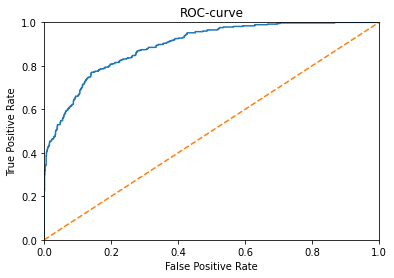

In [61]:
def make_roc_curve(y_test, pred_test):
    fpr, tpr, thresholds = roc_curve(y_test, pred_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve')
    plt.show()
    
make_roc_curve(y_test, model_cb.predict_proba(X_test)[:, 1])

In [62]:
accuracy_cb_t = accuracy_score(y_test, model_cb.predict(X_test))
print(f"accuracy для модели CatBoost на тестовой выборке: {accuracy_cb_t:.3f}")

accuracy для модели CatBoost на тестовой выборке: 0.842


- Рассмотрим долю вклада каждого признака в итоговое предстказание

In [63]:
feat_import = pd.DataFrame(data = {'feature': X_train.columns, 'percent': model_cb.feature_importances_})
feat_import.sort_values('percent', ascending=False).reset_index(drop=True)

,feature,percent
0,lifetime,64.936403
1,Type,10.751471
2,MonthlyCharges,6.295070
3,TotalCharges,4.071690
4,fiber_optic,3.854721
5,OnlineSecurity,2.186415
6,MultipleLines,1.795998
7,TechSupport,1.443531
8,PaymentMethod,1.377155
9,PaperlessBilling,0.838644


<a id='секция3'></a>
# 3. Общий вывод

- Проведён анализ признаков и выявлены следующие инсайты.  
    - в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся
    - многие ушедшие клиенты расплачивались методом 'Electronic check'
    - большинство ушедших клиентов были подключены по оптоволокну.
    - среди клиентов, не пользовавшихся услугами интернета (fiber_optic = -1), отток сравнительно небольшой  
- Обучены различные модели бинарной классификации для предсказания оттока клиентов. Для проверки качества моделей использовались метрики roc_auc и accuracy.  
  
| модель | roc_auc cv | roc_auc test | accuracy |  
|:------|:----------:|:------------:|:--------:|  
| base-line | - | 0.5 | 0.734 |  
| Логистическая регрессия | 0.846 | - | 0.802 |  
| Random Forest | 0.864 | 0.859 | 0.811 |  
| **CatBoost** | 0.889 | **0.894** | 0.842 |  
  
- Наилучшее качество предсказания показала модель градиентного бустинга (CatBoost). **roc_auc = 0.894** на тестовой выборке, accuracy = 0.902  
- Наибольший вклад в предсказание модели вносят признаки:
    - `lifetime` - количество месяцев, которое клиент пользуется сервисами
    - `Type` - тип платежей (ежемесячный, ежегодный, раз в два года)
    - `MonthlyCharges` - ежемесячный платёж за услуги. Для ушедших пользователей этот показатель выше.
    - `TotalCharges` - общая сумма, которую клиент заплатил за всё время услуг
    - `fiber_optic` - использование оптоволокна при подключении к интернету